# Instrument synergy

The purpose of this notebook is to prototype support for multiple instruments operating on the same signal incident at Earth. The instruments may have different wavebands and the data may or may not be phase resolved for each instrument.

Some extra data files not available on the GitHub repository are needed to run this tutorial. They can be found in the [Zenodo](https://zenodo.org/record/7094144) and should be placed in the directory `examples/examples_modeling_tutorial/model_data/` of your local xpsi directory.  These are the required files: 
- `nicer_v1.01_arf.txt`
- `nicer_v1.01_rmf_matrix.txt`
- `nicer_v1.01_rmf_energymap.txt`

In [1]:
%matplotlib inline

import os
import numpy as np
import math
import time

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm
rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

import xpsi

from xpsi.global_imports import _c, _G, _dpr, gravradius, _csq, _km, _2pi
from xpsi.utilities import PlottingLibrary as XpsiPlot

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.2.7               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported emcee version: 3.1.4
Imported PyMultiNest.
Check your UltraNest installation.
Check your installation of UltraNest if using the UltranestSampler
Imported GetDist version: 1.4
Imported nestcheck version: 0.2.1


In [2]:
class Telescope(object):
    pass

In [3]:
NICER = Telescope()
XMM = Telescope() # fabricated toy that we'll just pretend is XMM as a placeholder!

## Likelihood

Let us load a synthetic data set that we generated in advance, and know the fictitious exposure time for.

In [4]:
obs_settings = dict(counts=np.loadtxt('../../examples/examples_modeling_tutorial/model_data/example_synthetic_realisation.dat', dtype=np.double),
                    channels=np.arange(20, 201),
                    phases=np.linspace(0.0, 1.0, 33),
                    first=0,last=180,
                    exposure_time=984307.6661)

NICER.data = xpsi.Data(**obs_settings)

Setting channels for event data...
Channels set.


In [5]:
obs_settings = dict(counts=np.loadtxt('../../examples/examples_modeling_tutorial/model_data/XMM_realisation.dat', dtype=np.double).reshape(-1,1),
                    channels=np.arange(20, 201),
                    phases=np.array([0.0, 1.0]),
                    first=0,last=180,
                    exposure_time=1818434.247359)

XMM.data = xpsi.Data(**obs_settings)

Setting channels for event data...
Channels set.


In [6]:
rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

def veneer(x, y, axes, lw=1.0, length=8, yticks=None):
    """ Make the plots a little more aesthetically pleasing. """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())
        
    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())
        
    axes.tick_params(which='major', colors='black', length=length, width=lw)
    axes.tick_params(which='minor', colors='black', length=int(length/2), width=lw)
    plt.setp(axes.spines.values(), linewidth=lw, color='black')
    if yticks:
        axes.set_yticks(yticks)

def plot_one_pulse(pulse, x, data, label=r'Counts',
                   cmap=cm.magma, vmin=None, vmax=None,
                   yticks=[20,50,100,200]):
    """ Plot a pulse resolved over a single rotational cycle. """
    
    fig = plt.figure(figsize = (7,7))

    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1])
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])    
    
    # Calculate the centre of phase bins (required by pcolormesh instead of phase edges)
    _phase_bincenter = x[:-1]+0.5*(x[1]-x[0])
    
    profile = ax.pcolormesh(_phase_bincenter,
                             data.channels,
                             pulse,
                             cmap = cmap,
                             vmin=vmin,
                             vmax=vmax,
                             linewidth = 0,
                             rasterized = True)

    profile.set_edgecolor('face')

    ax.set_xlim([0.0, 1.0])
    ax.set_yscale('log')
    ax.set_ylabel(r'Channel')
    ax.set_xlabel(r'Phase')

    cb = plt.colorbar(profile,
                      cax = ax_cb)

    cb.set_label(label=label, labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((0.05, 0.2), (None, None), ax, yticks=yticks)

    plt.subplots_adjust(wspace = 0.025)
    
    if yticks is not None:
        ax.set_yticklabels(yticks)

Now for the data:

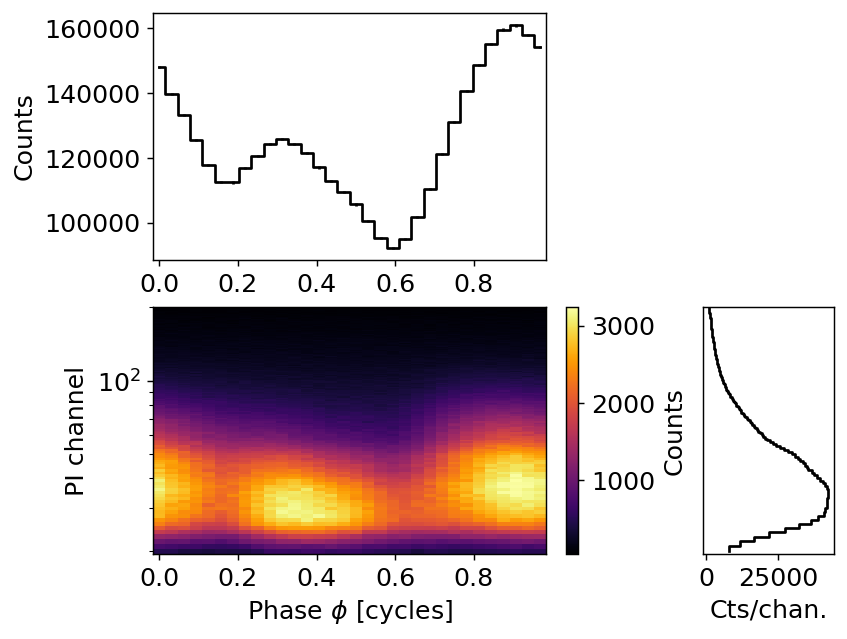

In [7]:
fig, axs = NICER.data.plot(dpi=130, num_rot=1)

XMM data is a spectrum. The array shape is : (181, 1)
NICER data is a pulse profile. They array shape is : (181, 32)


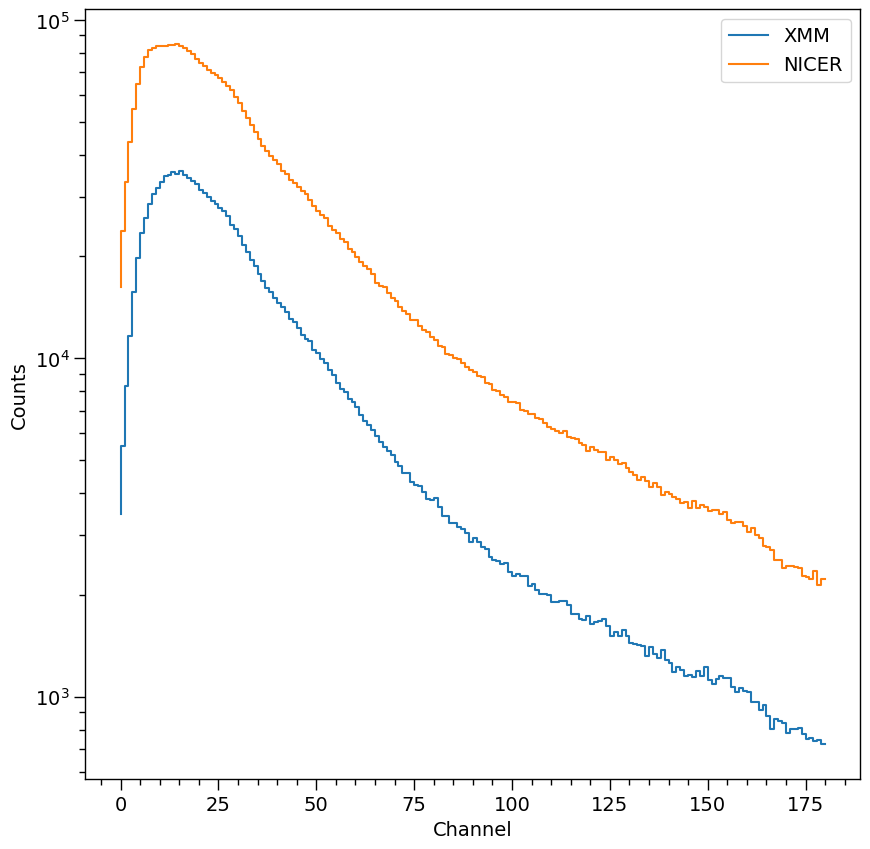

In [8]:
print(f"XMM data is a spectrum. The array shape is : {np.shape(XMM.data.counts)}")
print(f"NICER data is a pulse profile. They array shape is : {np.shape(NICER.data.counts)}") 

data_to_plot = [XMM.data.counts,
                np.sum(NICER.data.counts, axis=1)]  # Summing the NICER pulse profile over phase-bin to make spectrum
label_to_plot = ['XMM', 'NICER']

XpsiPlot.plot_spectrum(all_data=data_to_plot, 
                       all_labels=label_to_plot)

### Instrument

We require a model instrument object to transform incident specific flux signals into a form which enters directly in the sampling distribution of the data.

In [9]:
class CustomInstrument(xpsi.Instrument):
    """ A model of the NICER telescope response. """
    
    def __call__(self, signal, *args):
        """ Overwrite base just to show it is possible.
        
        We loaded only a submatrix of the total instrument response
        matrix into memory, so here we can simplify the method in the
        base class.
        
        """

        matrix = self.construct_matrix()

        self._folded_signal = np.dot(matrix, signal)
        
        return self._folded_signal

    @classmethod
    def from_response_files(cls, ARF, RMF, channel_edges, max_input, min_input=0,
                            translate_edges=None, scaling=None, inst_name=None):
        """ Constructor which converts response files into :class:`numpy.ndarray`s.
        :param str ARF: Path to ARF which is compatible with
                                :func:`numpy.loadtxt`.
        :param str RMF: Path to RMF which is compatible with
                                :func:`numpy.loadtxt`.
        :param str channel_edges: Path to edges which is compatible with
                                  :func:`numpy.loadtxt`.
        :param float translate_edges: Optional translation of the energy edges (in keV).
        :param float scaling: Optional Scaling to scale the ARF.
        
        """

        if min_input != 0:
            min_input = int(min_input)

        max_input = int(max_input)

        try:
            ARF = np.loadtxt(ARF, dtype=np.double, skiprows=3)
            RMF = np.loadtxt(RMF, dtype=np.double)
            channel_edges = np.loadtxt(channel_edges, dtype=np.double, skiprows=3)[:,1:]
        except:
            print('A file could not be loaded.')
            raise
            
        if scaling is not None:
            ARF[:,3] *= scaling
            
        matrix = np.ascontiguousarray(RMF[min_input:max_input,20:201].T, dtype=np.double)

        edges = np.zeros(ARF[min_input:max_input,3].shape[0]+1, dtype=np.double)

        edges[0] = ARF[min_input,1]; edges[1:] = ARF[min_input:max_input,2]

        for i in range(matrix.shape[0]):
            matrix[i,:] *= ARF[min_input:max_input,3]

        channels = np.arange(20, 201)
        
        if translate_edges is not None:
            edges += translate_edges

        return cls(matrix, edges, channels, channel_edges[20:202,-2], name=inst_name)

Let's construct an instance of the first instrument called `NICER`. This is made from RMF and ARF in ASCII (text) file format, but a new loader from FITS file is available (see "Modelling" tutorial).

In [10]:
NICER.instrument = CustomInstrument.from_response_files(ARF = '../../examples/examples_modeling_tutorial/model_data/nicer_v1.01_arf.txt',
                                         RMF = '../../examples/examples_modeling_tutorial/model_data/nicer_v1.01_rmf_matrix.txt',
                                         channel_edges = '../../examples/examples_modeling_tutorial/model_data/nicer_v1.01_rmf_energymap.txt',
                                         max_input = 500,
                                         min_input = 0,
                                         inst_name='NICER XTI')

Setting channels for loaded instrument response (sub)matrix...
Channels set.
No parameters supplied... empty subspace created.


'NICER XTI'

For the second instrument, called `XMM`, we use the some response files (those of `NICER`) with two additional arbitrary modifications (for the sake of the example):
- add a `scaling=0.5` which reduces the sensitivity by half (see `CustomInstrument` class above).
- add a `translate_edges=0.1` which shifts the sensitivity matrix by 0.1 keV.

In [11]:
XMM.instrument = CustomInstrument.from_response_files(ARF = '../../examples/examples_modeling_tutorial/model_data/nicer_v1.01_arf.txt',
                                       RMF = '../../examples/examples_modeling_tutorial/model_data/nicer_v1.01_rmf_matrix.txt',
                                       channel_edges = '../../examples/examples_modeling_tutorial/model_data/nicer_v1.01_rmf_energymap.txt',
                                       max_input = 500,
                                       min_input = 0,
                                       translate_edges = 0.1,
                                       scaling = 0.5,
                                       inst_name='XMM')

Setting channels for loaded instrument response (sub)matrix...
Channels set.
No parameters supplied... empty subspace created.


The NICER ``v1.01`` response matrix:

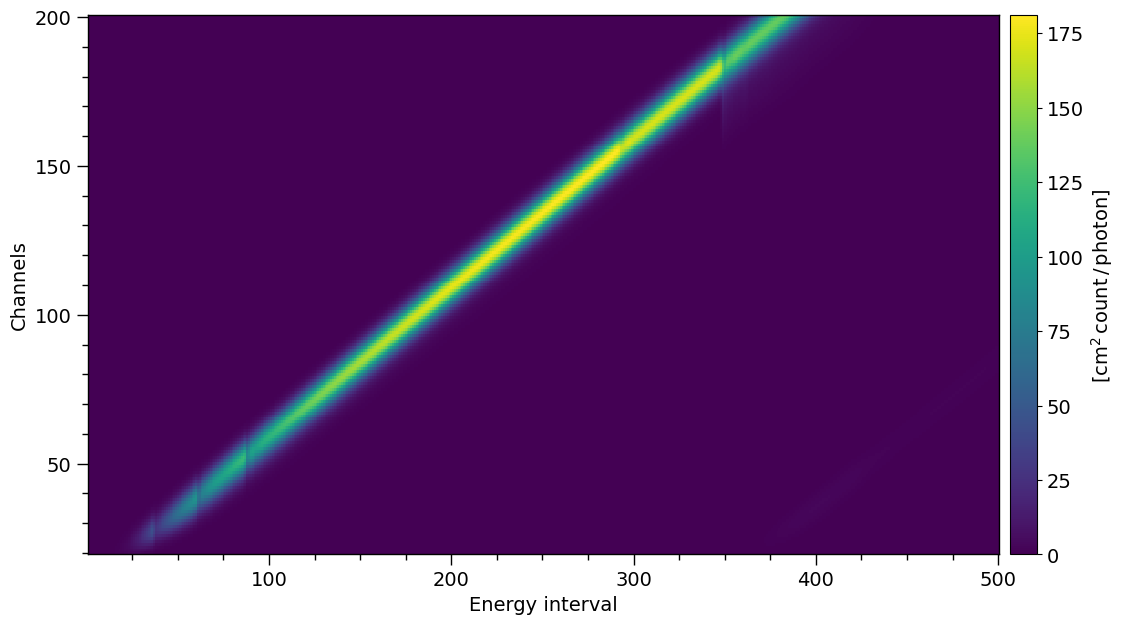

In [12]:
energy_inputs = np.arange(1,len( NICER.instrument.energy_edges)+1)-0.5
channels = NICER.instrument.channel_edges * 100 - 0.5

rmf_plot = XpsiPlot.plot_rmf(matrix=NICER.instrument.matrix,
                             x=energy_inputs,
                             y=channels,
                             xlabel='Energy interval',                        
                             ylabel='Channels'
                            )

XpsiPlot.veneer((25, 100), (10, 50), rmf_plot)

Summed over channel subset $[20,200]$:

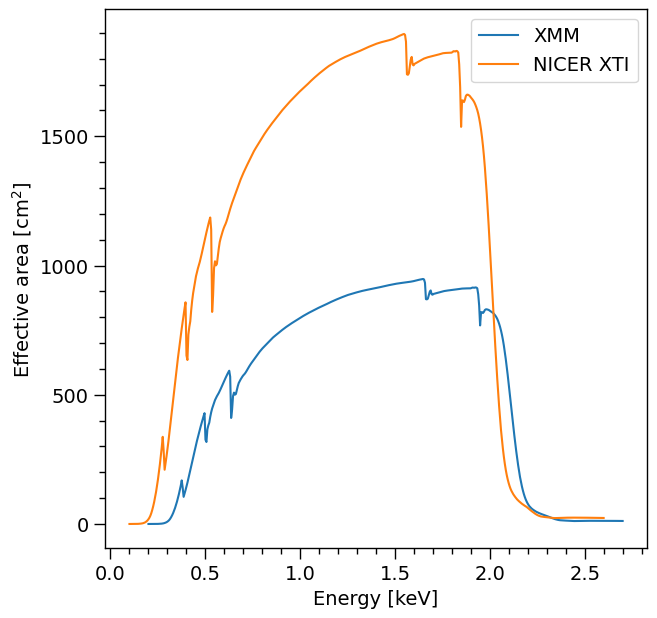

In [13]:
# fig = plt.figure(figsize = (10,10))

# ax = fig.add_subplot(111)
# veneer((0.1, 0.5), (50,250), ax)

# ax.plot((NICER.instrument.energy_edges[:-1] + NICER.instrument.energy_edges[1:])/2.0,
#         np.sum(NICER.instrument.matrix, axis=0), 'k-',label='NICER')

# ax.plot((XMM.instrument.energy_edges[:-1] + XMM.instrument.energy_edges[1:])/2.0,
#         np.sum(XMM.instrument.matrix, axis=0), 'r-', label='XMM')

# ax.legend()
# ax.set_ylabel('Effective area [cm$^{2}$]')
# _ = ax.set_xlabel('Energy [keV]')

arfplot = XpsiPlot.plot_arf([XMM.instrument, NICER.instrument])
XpsiPlot.veneer((0.1, 0.5), (100, 500), arfplot)

### Signal

In [14]:
from xpsi.likelihoods.default_background_marginalisation import eval_marginal_likelihood
from xpsi.likelihoods.default_background_marginalisation import precomputation

class CustomSignal(xpsi.Signal):
    """ A custom calculation of the logarithm of the likelihood.
    We extend the :class:`xpsi.Signal.Signal` class to make it callable.
    We overwrite the body of the __call__ method. The docstring for the
    abstract method is copied.
    """

    def __init__(self, workspace_intervals = 1000, epsabs = 0, epsrel = 1.0e-8,
                 epsilon = 1.0e-3, sigmas = 10.0, support = None, *args, **kwargs):
        """ Perform precomputation. """

        super(CustomSignal, self).__init__(*args, **kwargs)

        try:
            self._precomp = precomputation(self._data.counts.astype(np.int32))
        except AttributeError:
            print('Warning: No data... can synthesise data but cannot evaluate a '
                  'likelihood function.')
        else:
            self._workspace_intervals = workspace_intervals
            self._epsabs = epsabs
            self._epsrel = epsrel
            self._epsilon = epsilon
            self._sigmas = sigmas
            if support is not None:
                self._support = support
            else:
                self._support = -1.0 * np.ones((self._data.counts.shape[0],2))
                self._support[:,0] = 0.0
        
    @property
    def support(self):
        return self._support

    @support.setter
    def support(self, obj):
        self._support = obj

    def __call__(self, **kwargs):
        self.loglikelihood, self.expected_counts, self.background_signal, self.background_given_support = \
                eval_marginal_likelihood(self._data.exposure_time,
                                          self._data.phases,
                                          self._data.counts,
                                          self._signals,
                                          self._phases,
                                          self._shifts,
                                          self._precomp,
                                          self._support,
                                          self._workspace_intervals,
                                          self._epsabs,
                                          self._epsrel,
                                          self._epsilon,
                                          self._sigmas,
                                          kwargs.get('llzero'))

Note that if we need an additional overall phase shift parameter for additional instruments whose recorded data are phase resolved, then it could be passed to the subclass above for the signal associated with a given telescope.

In [15]:
NICER.signal = CustomSignal(data = NICER.data,
                              instrument = NICER.instrument,
                              background = None,
                              interstellar = None,
                              workspace_intervals = 1000,
                              epsrel = 1.0e-8,
                              epsilon = 1.0e-3,
                              sigmas = 10.0)

Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].


In [16]:
XMM.signal = CustomSignal(data = XMM.data,
                               instrument = XMM.instrument,
                               background = None,
                               interstellar = None,
                               support = None,
                               workspace_intervals = 1000,
                               epsrel = 1.0e-8,
                               epsilon = 1.0e-3,
                               sigmas = 10.0)

Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].


### Star

In [17]:
bounds = dict(distance = (None, None),                   # (Earth) distance
                mass = (None, None),                     # mass
                radius = (None, None),                   # equatorial radius
                cos_inclination = (None, None))          # (Earth) inclination to rotation axis

values = dict(frequency=300.0 )                          # spin frequency

spacetime = xpsi.Spacetime(bounds=bounds, values=values)

Creating parameter:
    > Named "frequency" with fixed value 3.000e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e-03, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [1.000e+00, 2.000e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-02, 3.000e+01].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [-1.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


In [18]:
bounds = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (-0.5, 0.5),
              super_temperature = (None, None))

# a simple circular, simply-connected spot
primary = xpsi.HotRegion(bounds=bounds,
                            values={}, # no initial values and no derived/fixed
                            symmetry=True,
                            omit=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            num_leaves=100,
                            num_rays=200,
                            do_fast=False,
                            prefix='p') # unique prefix needed because >1 instance

Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [-5.000e-01, 5.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "super_temperature" with bounds [3.000e+00, 7.600e+00].
    > log10(superseding region effective temperature [K]).


In [19]:
class derive(xpsi.Derive):
    def __init__(self):
        """
        We can pass a reference to the primary here instead
        and store it as an attribute if there is risk of
        the global variable changing.
        
        This callable can for this simple case also be
        achieved merely with a function instead of a magic
        method associated with a class.
        """
        pass

    def __call__(self, boundto, caller = None):
        # one way to get the required reference
        global primary # unnecessary, but for clarity
        return primary['super_temperature'] - 0.2
    
bounds['super_temperature'] = None # declare fixed/derived variable

secondary = xpsi.HotRegion(bounds=bounds, # can otherwise use same bounds
                              values={'super_temperature': derive()}, # create a callable value
                              symmetry=True,
                              omit=False,
                              cede=False,
                              concentric=False,
                              sqrt_num_cells=32,
                              min_sqrt_num_cells=10,
                              max_sqrt_num_cells=100,
                              num_leaves=100,
                              num_rays=200,
                              do_fast=False,
                              is_antiphased=True,
                              prefix='s') # unique prefix needed because >1 instance

Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [-5.000e-01, 5.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "super_temperature" that is derived from ulterior variables.
    > log10(superseding region effective temperature [K]).


In [20]:
from xpsi import HotRegions

hot = HotRegions((primary, secondary))

In [21]:
class CustomPhotosphere(xpsi.Photosphere):
    """ Implement method for imaging."""
    
    def _global_variables(self):
    
        return np.array([self['p__super_colatitude'],
                          self['p__phase_shift'] * _2pi,
                          self['p__super_radius'],
                          self['p__super_temperature'],
                          self['s__super_colatitude'],
                          (self['s__phase_shift'] + 0.5) * _2pi,
                          self['s__super_radius'],
                          self.hot.objects[1]['s__super_temperature']])

In [22]:
photosphere = CustomPhotosphere(hot = hot, elsewhere = None,
                                values=dict(mode_frequency = spacetime['frequency']))

Creating parameter:
    > Named "mode_frequency" with fixed value 3.000e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].


In [23]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

In [24]:
likelihood = xpsi.Likelihood(star = star, signals = [NICER.signal, XMM.signal],
                             threads = 1, externally_updated = False)

The instrument wavebands exhibit a high degree of overlap. The energies at which we compute incident specific flux signals are based on the union of wavebands, distributed logarithmically:

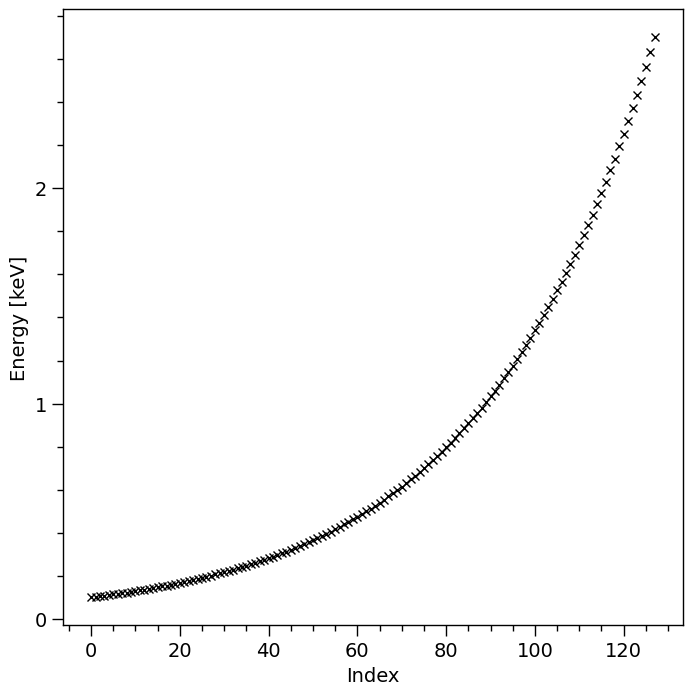

In [25]:
fig = plt.figure(figsize=(8,8))
plt.plot(XMM.signal.energies, 'kx')
ax = plt.gca()
veneer((5,20),(0.2,1.0),ax)
ax.set_xlabel('Index')
_ = ax.set_ylabel('Energy [keV]')

This is a simple, non-adaptive protocol to ensure that signals are not computed at very nearby energies for multiple telescopes, resulting in overhead.

Let's call the ``likelihood`` object with the true model parameter values that we injected to generate the synthetic data rendered above, omitting background parameters:

In [26]:
p = [1.4,
     12.5,
     0.2,
     math.cos(1.25),
     0.0,
     1.0,
     0.075,
     6.2,
     0.025,
     math.pi - 1.0,
     0.2]

t = time.time()
ll = likelihood(p, force=True) # force if you want to clear parameter value caches

print('ll = %.8f; time = %.3f' % (ll, time.time() - t))

ll = -30149.48498643; time = 0.713


In [27]:
NICER.signal.loglikelihood # check NICER ll ~ -26713.602 ?

-27540.643950720496

In [28]:
XMM.signal.loglikelihood # check XMM ll ~ -2608.841 ?

-2608.841035710165

Let's fabricate some rough prior information as the constrained support of the background parameters for XMM:

In [29]:
support = np.zeros((181, 2))
support[:,0] = XMM.signal.background_signal - 5.0 * np.sqrt(XMM.signal.background_signal)
support[:,1] = XMM.signal.background_signal + 5.0 * np.sqrt(XMM.signal.background_signal)
support /= XMM.data.exposure_time

In [30]:
XMM.signal.support = support

In [31]:
ll = likelihood(p, force=True)

Let's confirm that the XMM background-marginalised likelihood did indeed change:

In [32]:
XMM.signal.loglikelihood

-2610.1216095309114

The background-marginalised likelihood function has the following form. Subscripts N denote NICER, whilst subscripts X denote XMM.

$$
\begin{aligned}
p(d_{\rm X}, d_{\rm N}, \{b_{\rm X}\} \,|\, s)
    \propto
    &
    \underbrace{\mathop{\int}_{\{0\}}^{\{\mathcal{U}_{\rm N}\}}
    p(d_{\rm N} \,|\, s, \{\mathbb{E}[b_{\rm N}]\}, \texttt{NICER})
    d\{\mathbb{E}[b_{\rm N}]\}}_{\rm exp( \texttt{NICER.signal.loglikelihood} )}\\
    &
    \times\underbrace{\mathop{\int}_{\{0\}}^{\{\mathcal{U}_{X}\}}
    p(d_{\rm X} \,|\, s, \{\mathbb{E}[b_{\rm X}]\}, \texttt{XMM})
    p(\{\mathbb{E}[b_{\rm X}]\} \,|\, \{b_{\rm X}\})d\{\mathbb{E}[b_{\rm X}]\}}_{\rm exp( \texttt{XMM.signal.loglikelihood} )}.
\end{aligned}
$$

The term $p(\{\mathbb{E}[b_{\rm X}]\} \,|\, \{b_{\rm X}\})$ truncates the integral over XMM channel-by-channel background count rate variables to an interval $[a,b]$ in each channel, where $a,b\in\mathbb{R}^{+}$. This is the joint prior support of the variables $\{\mathbb{E}[b_{\rm X}]\}$ rendered in the spectral plot below. The form of the prior density $p(\{\mathbb{E}[b_{\rm X}]\} \,|\, \{b_{\rm X}\})$ is flat on this interval for each channel. This is a simplifying approximation to the probability of the background data $\{b_{\rm X}\}$ given the variables $\{\mathbb{E}[b_{\rm X}]\}$.

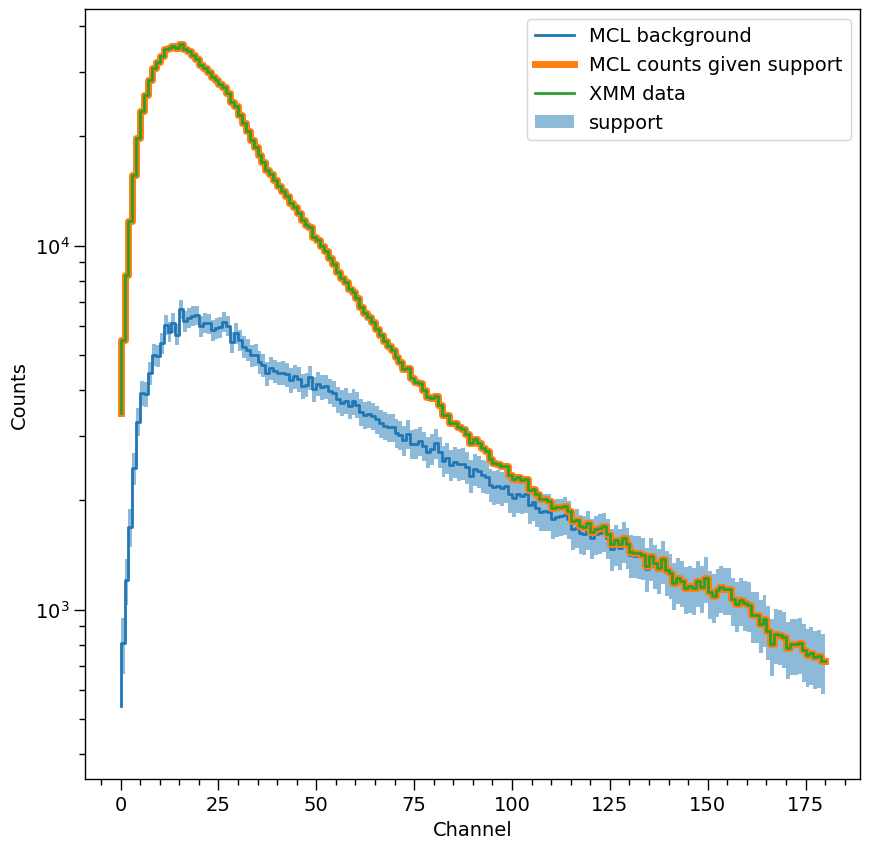

In [37]:
support_data = [support[:,0]*XMM.data.exposure_time, support[:,1]*XMM.data.exposure_time ]

data_to_plot = [XMM.signal.background_signal,
                XMM.signal.expected_counts,
                XMM.data.counts,
                support_data
               ]
label_to_plot = ['MCL background', 
                 'MCL counts given support',
                'XMM data',
                 'support'
                ]

XpsiPlot.plot_spectrum(data_to_plot, all_labels=label_to_plot, thickness=[2,5,2,14])

The spectrum labelled *MCL counts given support* means the expected signal from the pulsar, plus the background count vector that maximises the conditional likelihood function given that pulsar signal, subject to the background vector existing in the prior support. The spectrum labelled *MCL background*, on the other hand, is the background vector that maximises the conditional likelihood function, but *not* subject to the prior support.

In [38]:
likelihood['p__super_temperature'] = 6.1

In [39]:
likelihood.externally_updated = True

In [40]:
likelihood()

-387707.91812692466

In [41]:
XMM.signal.loglikelihood

-321117.06212712376

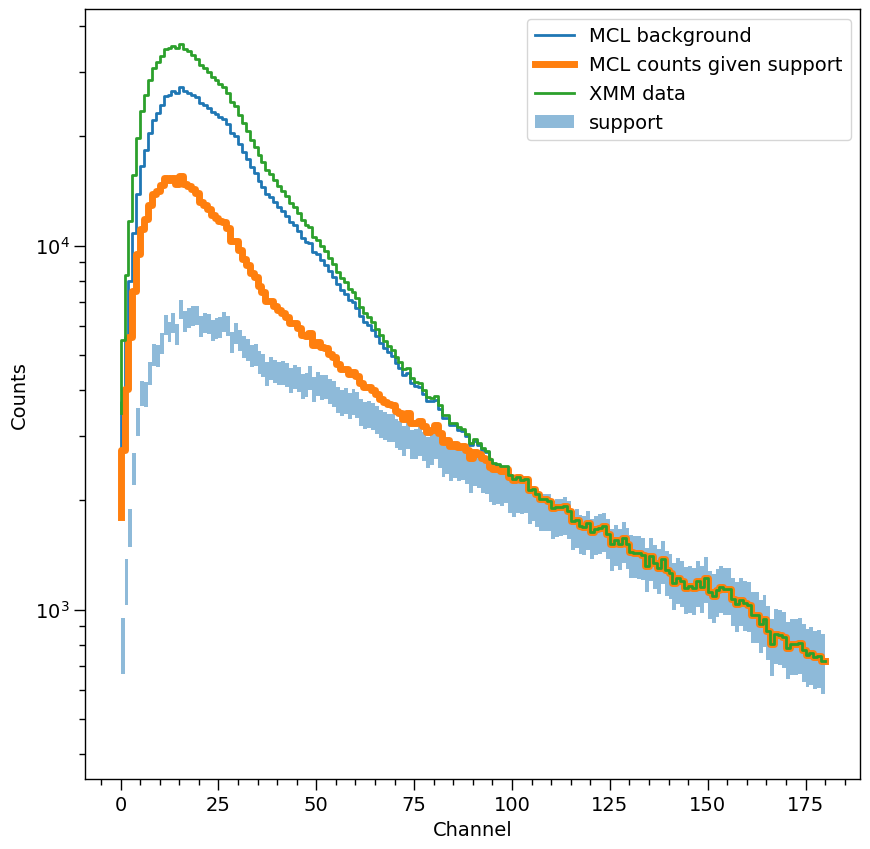

In [43]:
support_data = [support[:,0]*XMM.data.exposure_time, support[:,1]*XMM.data.exposure_time ]

data_to_plot = [XMM.signal.background_signal,
                XMM.signal.expected_counts,
                XMM.data.counts,
                support_data
               ]
label_to_plot = ['MCL background', 
                 'MCL counts given support',
                 'XMM data',
                 'support'
                ]

XpsiPlot.plot_spectrum(data_to_plot, all_labels=label_to_plot, thickness=[2,5,2,14])

## Synthesis

In this notebook thus far we have not generated sythetic data. However, we did condition on synthetic data. Below we outline how that data was generated.

### Background

The background radiation field incident on the model instrument for the purpose of generating synthetic data was a time-invariant powerlaw spectrum, and was transformed into a count-rate in each output channel using the response matrix for synthetic data generation. We would reproduce this background here by writing a custom subclass as follows.

In [44]:
class CustomBackground(xpsi.Background):
    """ The background injected to generate synthetic data. """

    def __init__(self, bounds=None, value=None):
        
        # first the parameters that are fundemental to this class
        doc = """
        Powerlaw spectral index.
        """
        index = xpsi.Parameter('powerlaw_index',
                                strict_bounds = (-3.0, -1.01),
                                bounds = bounds,
                                doc = doc,
                                symbol = r'$\Gamma$',
                                value = value,
                                permit_prepend = False) # because to be shared by multiple objects
        
        super(CustomBackground, self).__init__(index)

    def __call__(self, energy_edges, phases):
        """ Evaluate the incident background field. """
        
        G = self['powerlaw_index']

        temp = np.zeros((energy_edges.shape[0] - 1, phases.shape[0]))

        temp[:,0] = (energy_edges[1:]**(G + 1.0) - energy_edges[:-1]**(G + 1.0)) / (G + 1.0)

        for i in range(phases.shape[0]):
            temp[:,i] = temp[:,0]

        self._incident_background = temp

In [45]:
background = CustomBackground(bounds=(None, None)) # use strict bounds, but do not fix/derive

Creating parameter:
    > Named "powerlaw_index" with bounds [-3.000e+00, -1.010e+00].
    > Powerlaw spectral index.


We will use this same background signal, albeit with different normalisations, for both telescopes. This is simply to generate finite background contributions.

### Data format

We are also in need of a simpler data object.

In [46]:
class SynthesiseData(xpsi.Data):
    """ Custom data container to enable synthesis. """
    
    def __init__(self, channels, phases, first, last):
        self.channels = channels
        self._phases = phases
        
        try:
            self._first = int(first)
            self._last = int(last)
        except TypeError:
            raise TypeError('The first and last channels must be integers.')
        if self._first >= self._last:
            raise ValueError('The first channel number must be lower than the '
                             'the last channel number.')
        

Instantiate:

In [47]:
NICER.synth = SynthesiseData(np.arange(20,201), np.linspace(0.0, 1.0, 33), 0, 180)

Setting channels for event data...
Channels set.


In [48]:
XMM.synth = SynthesiseData(np.arange(20,201), np.array([0.0,1.0]), 0, 180)

Setting channels for event data...
Channels set.


### Custom method

In [49]:
from xpsi.tools.synthesise import synthesise_given_total_count_number as _synthesise

In [50]:
def synthesise(self,
               require_source_counts,
               require_background_counts,
               name='synthetic',
               directory='./data',
               **kwargs):
        """ Synthesise data set.

        """
        self._expected_counts, synthetic, _, _ = _synthesise(self._data.phases,
                                            require_source_counts,
                                            self._signals,
                                            self._phases,
                                            self._shifts,
                                            require_background_counts,
                                            self._background.registered_background,
                                            gsl_seed=0)
        try:
            if not os.path.isdir(directory):
                os.mkdir(directory)
        except OSError:
            print('Cannot create write directory.')
            raise

        np.savetxt(os.path.join(directory, name+'_realisation.dat'),
                   synthetic,
                   fmt = '%u')

        self._write(self.expected_counts,
                    filename = os.path.join(directory, name+'_expected_hreadable.dat'),
                    fmt = '%.8e')

        self._write(synthetic,
                    filename = os.path.join(directory, name+'_realisation_hreadable.dat'),
                    fmt = '%u')

def _write(self, counts, filename, fmt):
    """ Write to file in human readable format. """

    rows = len(self._data.phases) - 1
    rows *= len(self._data.channels)

    phases = self._data.phases[:-1]
    array = np.zeros((rows, 3))

    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            array[i*len(phases) + j,:] = self._data.channels[i], phases[j], counts[i,j]

    np.savetxt(filename, array, fmt=['%u', '%.6f'] + [fmt])

In [51]:
CustomSignal.synthesise = synthesise
CustomSignal._write = _write

We now need to instantiate, and reconfigure the likelihood object:

In [52]:
NICER.signal = CustomSignal(data = NICER.synth,
                              instrument = NICER.instrument,
                              background = background,
                              interstellar = None,
                              workspace_intervals = 1000,
                              epsrel = 1.0e-8,
                              epsilon = 1.0e-3,
                              sigmas = 10.0,
                              prefix='NICER')

XMM.signal = CustomSignal(data = XMM.synth,
                          instrument = XMM.instrument,
                          background = background,
                          interstellar = None,
                          workspace_intervals = 1000,
                          epsrel = 1.0e-8,
                          epsilon = 1.0e-3,
                          sigmas = 10.0,
                          prefix='XMM')

for h in hot.objects:
    h.set_phases(num_leaves = 100)
    
likelihood = xpsi.Likelihood(star = star, signals = [NICER.signal, XMM.signal], threads=1)

Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].
Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].


### Synthesise

We proceed to synthesise. First we check the output path to write synthetic files:

In [53]:
!pwd

/Users/sebastien/Research/GitHub/xpsi/docs/source


In [54]:
likelihood

Free parameters
---------------
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].
powerlaw_index: Powerlaw spectral index.

In [55]:
p = [1.4,
     12.5,
     0.2,
     math.cos(1.25),
     0.0,
     1.0,
     0.075,
     6.2,
     0.025,
     math.pi - 1.0,
     0.2,
     -2.0]

NICER_kwargs = dict(require_source_counts = 2.0e6,
                      require_background_counts = 2.0e6,
                      name = 'new_NICER',
                      directory = './data')

XMM_kwargs = dict(require_source_counts = 1.0e6,
                      require_background_counts = 5.0e5,
                      name = 'new_XMM',
                      directory = './data')

likelihood.synthesise(p,
                      force = True,
                      NICER = NICER_kwargs,
                      XMM = XMM_kwargs)

Exposure time: 984282.620969 [s]
Background normalisation: 1.89132784e-05
Exposure time: 1818398.718453 [s]
Background normalisation: 2.21412640e-04


Notice that the normalisations, with units photons/s/cm^2/keV, are different because we require so many background counts. This detail is unimportant for this notebook, wherein we simply want some finite background contributions.

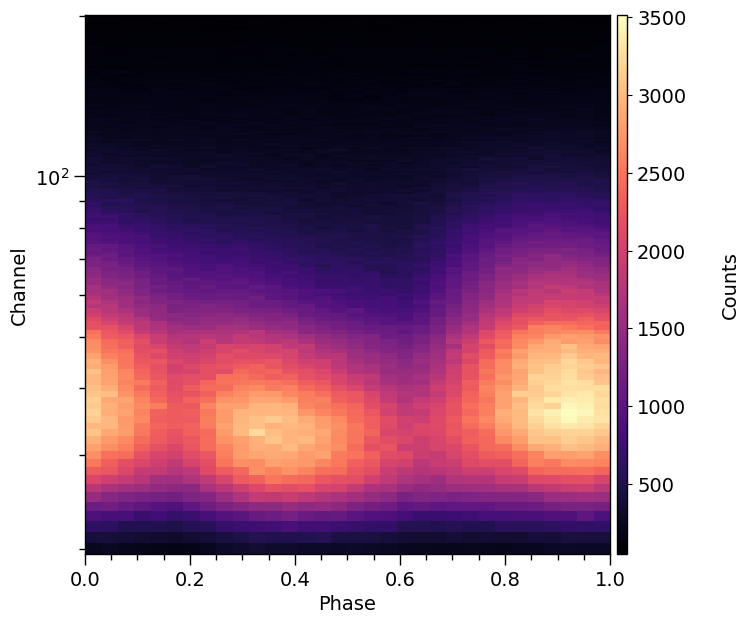

In [61]:
XpsiPlot.plot_2d_pulse(pulse=np.loadtxt('data/new_NICER_realisation.dat', dtype=np.double), 
                       x=NICER.data.phases,
                       y=NICER.data.channels,
                       rotations=1,
                       ylabel='Channel',
                       cbar_label='Counts',)

Check we have generated the same count numbers, given the same seed and resolution settings:

In [62]:
diff = XMM.data.counts - np.loadtxt('data/new_XMM_realisation.dat', dtype=np.double).reshape(-1,1)
(diff != 0.0).any()

True

In [63]:
diff = NICER.data.counts - np.loadtxt('data/new_NICER_realisation.dat', dtype=np.double)
(diff != 0.0).any()

True

As discussed in the `Modeling` tutorial, with `xpsi.__version__` of `v0.6`, the same RNG seed does not yield the same ($\pm1$) count numbers, despite the small fractional difference between Poisson random variable expectations, for reasons that are unclear at present.

In [64]:
x = np.loadtxt('../../examples/examples_modeling_tutorial/model_data/example_synthetic_expected_hreadable.dat')
y = np.loadtxt('data/new_NICER_expected_hreadable.dat')

xx = np.zeros(NICER.data.counts.shape)
yy = np.zeros(NICER.data.counts.shape)

for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        xx[i,j] = x[i*32 + j,-1]
        yy[i,j] = y[i*32 + j,-1]

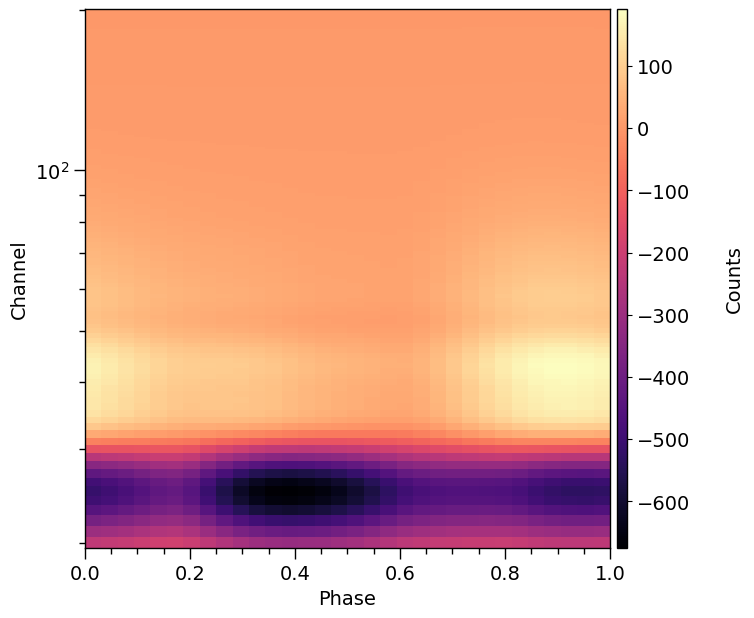

In [65]:
XpsiPlot.plot_2d_pulse(pulse=yy-xx, 
                       x=NICER.data.phases,
                       y=NICER.data.channels,
                       rotations=1,
                       ylabel='Channel',
                       cbar_label='Counts',)

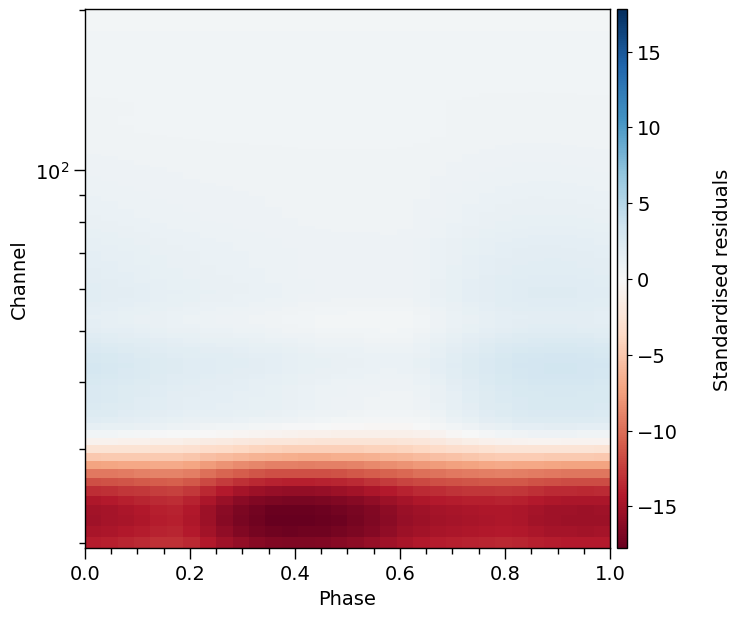

In [68]:
_r = (yy-xx)/np.sqrt(yy)
XpsiPlot.plot_2d_pulse(pulse=_r, 
                       x=NICER.data.phases,
                       y=NICER.data.channels,
                       rotations=1,
                       ylabel='Channel',
                       cbar_label='Standardised residuals',
                       cmap=cm.RdBu,
                       vmin=-np.max(np.fabs(_r)),
                       vmax=np.max(np.fabs(_r)))

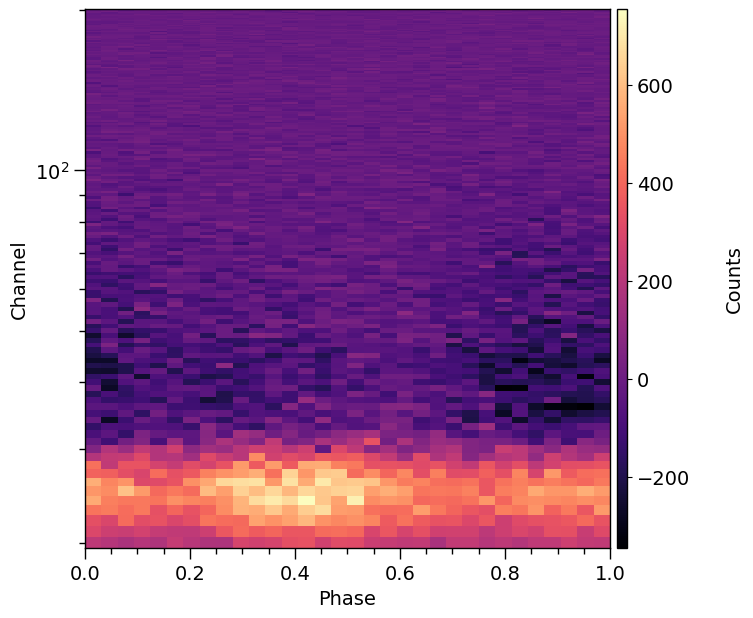

In [70]:
XpsiPlot.plot_2d_pulse(pulse=diff, 
                       x=NICER.data.phases,
                       y=NICER.data.channels,
                       rotations=1,
                       ylabel='Channel',
                       cbar_label='Counts',)